# Level-set-speed-computation
This notebook shows the Python implementation of computing speed term for level set surface evolution, described in paper:  
**Intelligent Initialization and Interactivity: Optimizing Level Sets for T1-weighted White Matter Segmentation** [[PDF]](http://interactivemedical.org/imic2014/CameraReadyPapers/Paper%2012/Xue_IMIC2014_CameraReady_Jul21.pdf)

The Ipython notebook is hosted at [nbviewer](http://nbviewer.ipython.org/github/wenzhexue/level-set-speed-computation/blob/master/brain-white-matter-seg.ipynb). You can also download the notebook and data from [here](https://github.com/wenzhexue/level-set-speed-computation).

In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
from sklearn import neighbors, datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import sqrt

In [2]:
print sitk.Version()

SimpleITK Version: 0.8.1
Compiled: Dec 19 2014 11:17:59



In [3]:
t1_img = sitk.ReadImage('./data/t1_icbm_normal_1mm_pn3_rf0.mhd')
t2_img = sitk.ReadImage('./data/t2_icbm_normal_1mm_pn3_rf0.mhd')

In [4]:
# read foreground and background seed points
foreground_seeds = np.genfromtxt('./data/foregroundSeedFile.txt', dtype=int)
background_seeds = np.genfromtxt('./data/backgroundSeedFile.txt', dtype=int)
# print "Show some sample seed points"
# print foreground_seeds[:10, :]
# print background_seeds[:10, :]

:0: FutureWarning: IPython widgets are experimental and may change in the future.


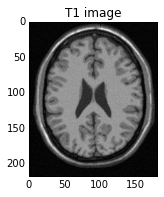

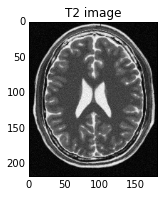

In [5]:
# show a slice with the seeds on
from myshow import myshow, myshow3d
myshow(t1_img[:, ::-1, 95], title='T1 image')
myshow(t2_img[:, ::-1, 95], title='T2 image')

myshow() is defined in SimpleITK notebook. You can download the code [here](https://github.com/SimpleITK/SimpleITK-Notebooks/blob/master/myshow.py).

In [6]:
foreground_intensities = np.zeros([len(foreground_seeds), 2])
for i, seed in enumerate(foreground_seeds):
    foreground_intensities[i, :] = [t1_img.GetPixel(*seed), 
                                    t2_img.GetPixel(*seed)]
background_intensities = np.zeros([len(background_seeds), 2])
for i, seed in enumerate(background_seeds):
    background_intensities[i, :] = [t1_img.GetPixel(*seed), 
                                    t2_img.GetPixel(*seed)]

The following figure shows seeds point on one slice of T1 image, foreground seeds (blue) in the white matter while background seeds (red) in part of gray matter and CSF regions. 

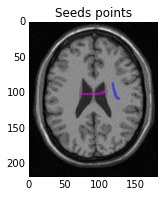

In [7]:
seeds_label_img = sitk.Image(t1_img.GetSize(), sitk.sitkUInt8)
t1_imgInt = sitk.Cast(sitk.RescaleIntensity(t1_img), seeds_label_img.GetPixelID())
for i, seed in enumerate(foreground_seeds):
    seeds_label_img.SetPixel(seed[0], seed[1], seed[2], 2)
for i, seed in enumerate(background_seeds):
    seeds_label_img.SetPixel(seed[0], seed[1], seed[2], 4)
myshow(sitk.LabelOverlay(t1_imgInt[:,::-1,95], seeds_label_img[:,::-1,95]), title='Seeds points')

In [8]:
# print foreground_intensities[:10, :]
# print background_intensities[:10, :]

In [9]:
X = np.concatenate((background_intensities, foreground_intensities), axis=0)
y = np.concatenate((np.zeros(len(background_intensities)),
                    np.ones(len(foreground_intensities))), axis=0)

In [10]:
t1_stats = sitk.StatisticsImageFilter()
t1_stats.Execute(t1_img)
t2_stats = sitk.StatisticsImageFilter()
t2_stats.Execute(t2_img)
t1_min, t1_max = t1_stats.GetMinimum(), t1_stats.GetMaximum()
t2_min, t2_max = t2_stats.GetMinimum(), t2_stats.GetMaximum()

# create meshgrid for feature space
h = 1
xx, yy = np.meshgrid(np.arange(t1_min, t1_max+1, h), 
                     np.arange(t2_min, t2_max+1, h))

In [11]:
n_neighbors_background = int(sqrt(len(background_intensities)))
knn_clf_background = neighbors.KNeighborsClassifier(n_neighbors_background)
knn_clf_background.fit(background_intensities, np.zeros(len(background_intensities)))
dist, temp = knn_clf_background.kneighbors(np.c_[xx.ravel(), yy.ravel()])
background_dist = np.average(dist, axis=1)

n_neighbors_foreground = int(sqrt(len(foreground_intensities)))
knn_clf_foreground = neighbors.KNeighborsClassifier(n_neighbors_foreground)
knn_clf_foreground.fit(foreground_intensities, np.zeros(len(foreground_intensities)))
dist, temp = knn_clf_foreground.kneighbors(np.c_[xx.ravel(), yy.ravel()])
foreground_dist = np.average(dist, axis=1)

Z_dist = (background_dist - foreground_dist) / (background_dist + foreground_dist)
Z_dist = Z_dist.reshape(xx.shape)
Z_dist.shape

(256, 256)

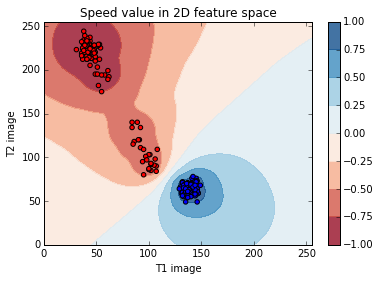

In [12]:
cm = plt.cm.RdBu
cm2 = plt.cm.RdYlGn
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig = plt.figure()
ax = plt.subplot(111)
cax = ax.contourf(xx, yy, Z_dist, cmap=cm, alpha=.8)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
ax.set_title('Speed value in 2D feature space')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('T1 image')
ax.set_ylabel('T2 image')
plt.colorbar(cax)

plt.show(fig)

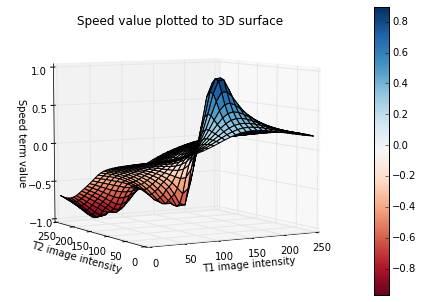

In [13]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

p = ax.plot_surface(xx[::8,::8], yy[::8,::8], Z_dist[::8,::8], rstride=1, cstride=1, cmap=cm)
ax.set_xlabel('T1 image intensity')
ax.set_ylabel('T2 image intensity')
ax.set_zlabel('Speed term value')
ax.set_title('Speed value plotted to 3D surface')
ax.view_init(elev=7, azim=-120)
plt.colorbar(p)
plt.show(fig)

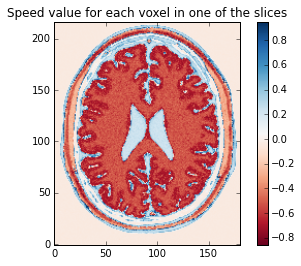

In [15]:
# compute the speed value for each voxel
w, h, num_slices = t1_img.GetSize()
speed_img = sitk.Image(w, h, num_slices, sitk.sitkFloat32)
speed_data = sitk.GetArrayFromImage(speed_img)
t1_data = sitk.GetArrayFromImage(t1_img)
t2_data = sitk.GetArrayFromImage(t2_img)
for ii, intensity in enumerate(speed_data[:]):
    speed_data[:][ii] = Z_dist[t1_data[:][ii], t2_data[:][ii]]

speed_img = sitk.GetImageFromArray(speed_data)
speed_plot = plt.imshow(speed_data[95, :, :])
speed_plot.set_cmap(cm)
plt.title('Speed value for each voxel in one of the slices')
plt.colorbar()
plt.gca().invert_yaxis()
# save the speed volume to a metadata file, which later can be loaded to levelset program
# sitk.WriteImage(speed_img, './data/speed_vol_icbm_normal_1mm_pn3_rf0.mhd')